In [25]:
import warnings;
warnings.filterwarnings('ignore');

import numpy as np
import scipy.signal as signal
import scipy.fftpack as fftpack
from scipy.io import wavfile
import matplotlib.pyplot as plt
from matplotlib import gridspec

# RDS Decoding

### Tuning to an FM channel

The first step is to tune in to the center frequency of the FM channel of interest and filter out any other channels.

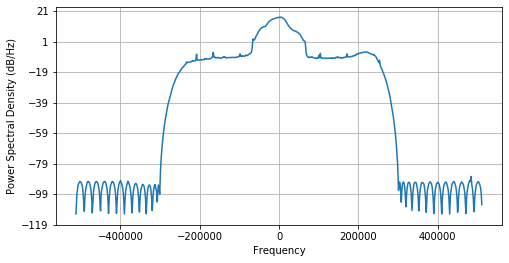

In [26]:
# FM station recorded using SDRsharp
fs, data = wavfile.read('SDRSharp_20191020_233227Z_106137280Hz_IQ.wav')
wo = 2*np.pi*-237280/fs

# Complex IQ representation of the data
IQ = data[:,0] + 1j*data[:,1]

# low pass filter for the FM channel bandwidth
channelFilt = signal.remez(50, [0, 200000, 300000, fs/2], [1,0], fs=fs)

# Demodulate the channel to baseband, then filter 
IQ = IQ*np.exp(-1j*wo*np.arange(IQ.shape[0]))
IQ = signal.convolve(IQ, channelFilt, mode='valid')

# Plot the spectrum of the FM channel
plt.figure(figsize= (8,4))
plt.psd(IQ, Fs=fs, NFFT = 1024)
plt.show()


### Demodulating the FM multiplex signal

Now we can decimate down to a lower sample rate and demodulate the FM-modulated channel. An efficient way of computing the demodulated signal, which amounts to taking the discrete derivative of the signal phase, is the following:

$Arg(y[n]y^*[n-1] )$

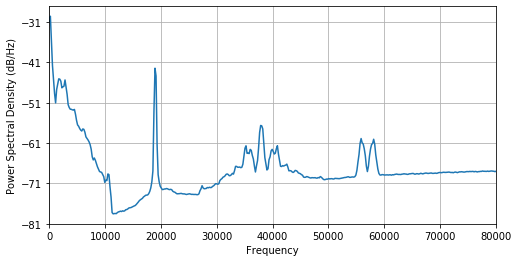

In [27]:
# Decimate to reduce the sample rate from 1.024 Msps to 192 ksps
fsM = 192000
IQ = signal.resample_poly(IQ, 3, 16)

# FM demodulation 
x0 = IQ[1:]
x1 = IQ[:-1]
MPX_FM = np.angle(x0*np.conj(x1))

# Plot the multiplex spectrum of the FM channel
plt.figure(figsize= (8,4))
plt.psd(MPX_FM, Fs=fsM, NFFT=1024)
plt.xlim([0, 80000])
plt.show()

The spectrum plotted above shows all the components of a typical FM broadcast channel. The first section is the mono audio section starting at 0 kHz. Next there is the stereo pilot tone (the sharp spike at 19kHz). The stereo audio channel is centered at 38kHz. Finally, the RDS data occupies a small bandwidth centered at 57kHz.

### Isolating the RDS subcarrier

Now we will filter out the audio signals (mono and stereo) and shift the RDS subcarrier down to an intermediate frequency (5kHz) for further processing.

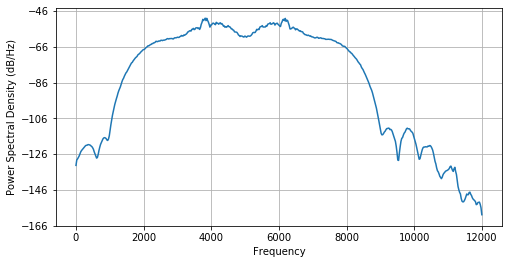

In [28]:
# filter out the audio signals
wo = 2*np.pi*57000/fsM  # RDS subcarrier frequency
RDSFilt = signal.remez(299,[0, 2000, 4000, fsM/2],[1,0], fs=fsM) 
RDSFilt57 = RDSFilt*np.cos(wo*np.arange(RDSFilt.shape[0]))
RDS_57 = 10*signal.convolve(MPX_FM, RDSFilt57, mode='same')

# shift the RDS signal down to an intermediate frequency (5kHz) and decimate
RDS_IF = RDS_57*np.cos(2*np.pi*np.arange(RDS_57.shape[0])*52000/fsM)
RDS_IF = signal.decimate(RDS_IF, 8)
fsIF = fsM/8
wF = 2*np.pi*5000/fsIF

# Plot the spectrum of the IF RDS signal
plt.figure(figsize= (8,4))
plt.psd(RDS_IF, Fs=fsIF, NFFT=1024)
plt.show()


### Obtaining the phase of the RDS subcarrier

The local oscillator of our radio is not frequency synchronized to the radio station's local oscillator. This causes our received signal to be modulated at a frequency equal to the difference between the two local oscillator frequencies. Fortunately, we can correct this difference by using a type of adaptive filter called a Costas loop. 

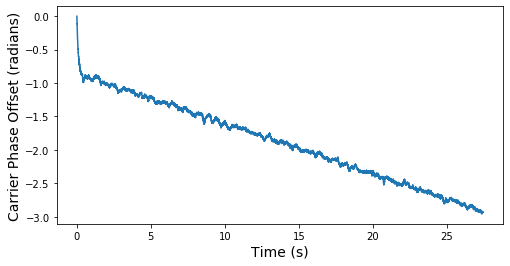

In [29]:
# This is a Costas loop implementation based on the Matlab code provided in 
# Telecommunication Breakdown, by C. Richard Johnson Jr. and William A. Sethares.

def phase_recovery(sig_in, flen, loop_gain, loop_bw, w, fs):
    '''
    INPUTS:
        sig_in: supressed-carrier signal to recover the phase from
        flen: length of loop filter
        loop_gain: loop gain for Costas loop
        loop_bw: bandwidth of loop filter
        w: expected carrier frequency in rad/s
        fs: sample rate of the input signal
    OUTPUT:
        theta: estimate of the carrier phase offset'''
    
    nn = np.arange(sig_in.shape[0])  
    zs = np.zeros((flen,))       # preallocate array for use in loop
    zc = np.zeros((flen,))
    loop_filt = signal.remez(flen, [0, loop_bw, 2*loop_bw, fs/2], [1, 0], fs = fs)
    theta = np.zeros(nn.shape) # array for storing carrier phase offset
    
    for k in range(len(nn)-1):
        zs = np.append(zs[1:], 2*sig_in[k]*np.sin(w*nn[k] + theta[k]))
        zc = np.append(zc[1:], 2*sig_in[k]*np.cos(w*nn[k] + theta[k]))
        lpfs = np.dot(loop_filt, zs)
        lpfc = np.dot(loop_filt, zc)
        theta[k+1] = theta[k] - loop_gain*lpfs*lpfc
    
    return theta

theta0 = phase_recovery(RDS_IF, 20, 0.03, 2000, 2*np.pi*5000/fsIF, fsIF)

# plot the obtained carrier phase
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(theta0))/fsIF, theta0)
plt.ylabel('Carrier Phase Offset (radians)', fontsize=14)
plt.xlabel('Time (s)', fontsize=14)
plt.show()




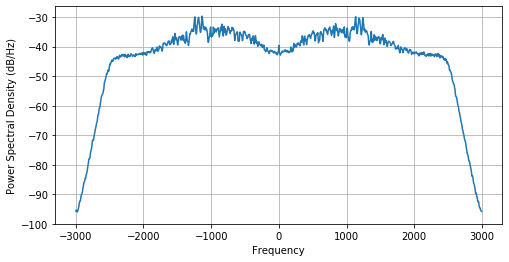

In [30]:
recovered_carrier = np.exp(-1j*(wF*np.arange(RDS_IF.shape[0]) + theta0))
uncorrected_carrier = np.exp(-1j*wF*np.arange(RDS_IF.shape[0]))

# Take the hilbert transform of the signal so that we can use complex 
# demodulation to get a nice looking constellation diagram.
# use fftpack.next_fast_len to determine fft length for fast hilbert transform computation-
# see https://github.com/scipy/scipy/issues/6324#issuecomment-425752155
RDS_IFc = signal.hilbert(RDS_IF, fftpack.next_fast_len(len(RDS_IF)))[:len(RDS_IF)]
RDS = RDS_IFc*recovered_carrier
RDS_uncorr0 = RDS_IF*uncorrected_carrier

# normalize
RDS = RDS/np.sqrt(np.mean(np.abs(RDS)**2))
RDS = signal.decimate(RDS, 4)
RDS_uncorr0 = RDS_uncorr0/np.sqrt(np.mean(np.abs(RDS_uncorr0)**2))
RDS_uncorr0 = signal.decimate(RDS_uncorr0, 4)
fsIF = fsIF / 4

# Plot the baseband RDS spectrum
plt.figure(figsize= (8,4))
plt.psd(RDS, Fs=fsIF, NFFT=1024)
plt.show()


### Demodulating the RDS BPSK signal

We can generate the RDS symbol carrier (1187.5 Hz) by dividing down the 57kHz subcarrier. These two carriers are phase-locked to one another so there is no need to do a second carrier phase recovery.


In [31]:
# Using the recovered 57kHz carrier phase to create a frequency synchronized 1187.5Hz symbol carrier
wc = 2*np.pi*1187.5/fsIF
nn = np.arange(RDS.shape[0]) 
theta0 = signal.decimate(theta0, 4)

recovered_carrier1187 = np.exp(1j*(wc*nn + theta0/(48*4)))

basefilt0 = signal.remez(96, [0, 1400, 1500, fsIF/2], [1, 0], fs = fsIF)

# demodulate the BPSK signal
RDS_demod = RDS*recovered_carrier1187
RDS_demod = signal.lfilter(basefilt0, 1.0, RDS_demod)

# Also demodulate without phase correction to compare
RDS_demod_uncorr01 = RDS_uncorr0*np.cos(wc*nn)
RDS_demod_uncorr01 = signal.lfilter(basefilt0, 1.0, RDS_demod_uncorr01)

# resample to 19ksps so that the sample rate is an integer multiple of the symbol rate
RDS_demod = signal.resample_poly(RDS_demod, 19,24)
RDS_demod_uncorr01 = signal.resample_poly(RDS_demod_uncorr01, 19,24)
nn = np.arange(RDS_demod.shape[0])

### Symbol Timing Recovery

Now it is time to recover the optimal sampling instants for the signal. This is probably not necessary for a low symbol rate transmission like RDS. Below is a simple method that chooses sampling locations by maximizing the output amplitude.


In [32]:
# number of symbols to include in each timing recovery block
block_N = 26

# preallocate space for the samples
RDS_sampled = np.zeros((int(RDS_demod.shape[0]/4),), dtype=complex)
all_sample_locations = np.array([])

# loop through the signal
for ii in range(int(RDS_demod.shape[0]/(block_N*4) - 1)):
    # get a chunk of length 48*block_N
    chunk = RDS_demod[ii*(block_N*4):(ii+1)*(block_N*4)]
    
    # create a 'comb' to pick out sample values
    sample_comb = np.zeros(chunk.shape)
    sample_comb[0:-1:4] = 1
    
    # determine the total signal power for each sampling offset
    signal_power = np.zeros((4,))
    for kk in range(4):
        xx = np.roll(sample_comb, kk).astype(bool)
        sa = np.real(chunk[xx])
        power = np.sum(sa**2)
        signal_power[kk] = power
    
    # fild the offset which maximizes the output power
    optimal_offset = np.argmax(signal_power)
    optimal_samples = np.roll(sample_comb, optimal_offset).astype(bool)
    
    # save the optimal samples and their indices
    RDS_sampled[ii*block_N:(ii+1)*block_N] = chunk[optimal_samples]
    all_sample_locations = np.concatenate((all_sample_locations, optimal_samples))

# Correct the constellation rotation 
aa = np.angle(RDS_sampled)

const_rotation = aa*(aa>0) + (aa + np.pi)*(aa<0)
mean_rotation = np.mean(const_rotation*(const_rotation < np.pi/2))
#RDS_sampled = RDS_sampled*np.exp(-1j*mean_rotation)



## Creating a constellation diagram

Making that cool dot picture with the dots. 
Also plotting the output waveform and the sample locations. 

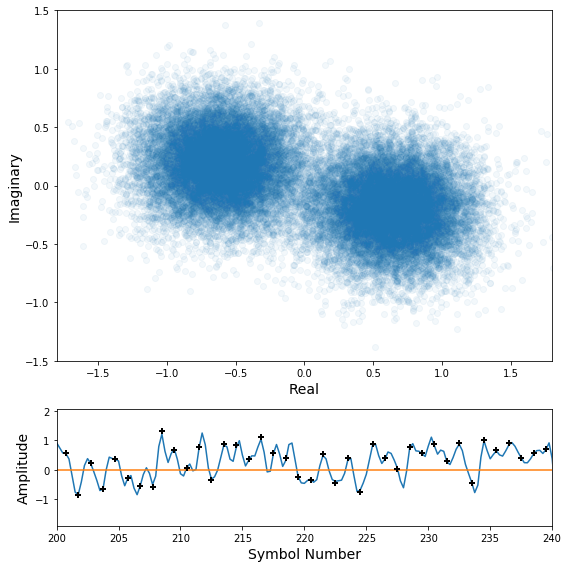

In [33]:
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

# plot the constellation diagram
ax0 = plt.subplot(gs[0])
plt.scatter(np.real(RDS_sampled[100:-100]), np.imag(RDS_sampled[100:-100]), alpha=0.05)
plt.ylim([-1.5, 1.5])
plt.xlim([-1.8, 1.8])
plt.xlabel('Real', fontsize=14)
plt.ylabel('Imaginary', fontsize=14)

# also plot a section of the output waveform and its sample locations.
ax1 = plt.subplot(gs[1])
plt.plot(nn/4, np.real(RDS_demod*np.exp(-1j*mean_rotation)))
plt.plot(nn/4, np.zeros(nn.shape))

sample_t = np.arange(all_sample_locations.shape[0])
sample_t = sample_t[all_sample_locations.astype(bool)]

plt.plot(sample_t/4 , RDS_sampled[0:sample_t.shape[0]], 'k+', mew = 2)
plt.xlim([200, 240])
plt.xlabel('Symbol Number', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)

plt.tight_layout()
plt.show()

### Comparing the output with and without carrier phase recovery and symbol timing recovery

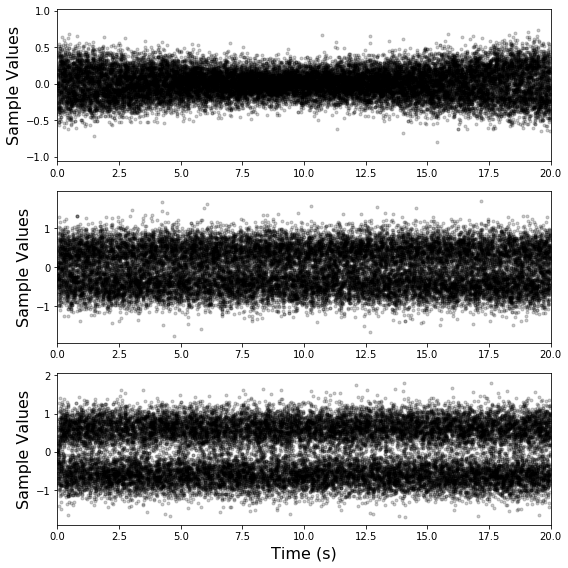

In [34]:
'''Plot the real part of the constellation diagram over time in order to compare 
the output with and without carrier phase and symbol timing recovery '''

RDS_sa_nosync = RDS_demod[::4]
RDS_sa_nosync_uncorr01 = RDS_demod_uncorr01[::4]

ns = np.arange(RDS_sampled.shape[0])
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(3, 1)

plt.subplot(gs[0])
plt.plot(ns.astype(float)/1187.5, np.real(RDS_sa_nosync_uncorr01[:-1]), 'k.', alpha = 0.2)
plt.ylabel('Sample Values', fontsize=16)
plt.xlim([0,20])

plt.subplot(gs[1])
plt.plot(ns.astype(float)/1187.5, RDS_sa_nosync[:-1], 'k.', alpha = 0.2)
plt.ylabel('Sample Values', fontsize=16)
plt.xlim([0,20])

plt.subplot(gs[2])
plt.plot(ns.astype(float)/1187.5, RDS_sampled, 'k.', alpha = 0.2)
plt.ylabel('Sample Values', fontsize=16)
plt.xlabel('Time (s)', fontsize=16)
plt.xlim([0,20])

plt.tight_layout()
plt.show()

(Top) No carrier phase synchronization or timing recovery. (Middle) With carrier phase synchronization but no symbol timing recovery. (Bottom) With carrier phase synchronization and symbol timing recovery.

### Decoding the received bitstream

RDS data is transmitted in groups comprising 26 bits. The first 16 bits are data bits and the remaining 10 form a checkword. The expected checkword can be determined by multiplying the data bits by the parity-check matrix H which is specified in the RDS standard (IEC 62106).


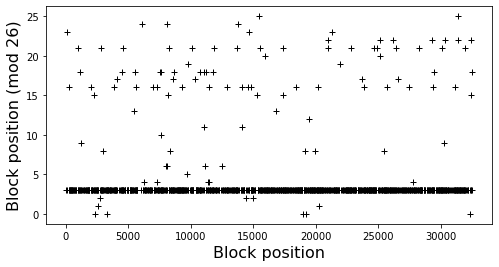

In [35]:
# Turn back now if using numpy arrays to do bitwise operations upsets you.

# Slicer: convert sample values to zeros and ones
RDS_bitstream = (np.sign(np.real(RDS_sampled))).astype(int)
RDS_bitstream[RDS_bitstream == -1] = 0

# differential decoding
RDS_bits = np.bitwise_xor(RDS_bitstream[1:], RDS_bitstream[:-1])

# syndromes corresponding to valid block types (see IEC 62106 p.64)
checkw = np.array([[1,1,1,1,0,1,1,0,0,0],
                  [1,1,1,1,0,1,0,1,0,0],
                  [1,0,0,1,0,1,1,1,0,0],
                  [1,1,1,1,0,0,1,1,0,0],
                  [1,0,0,1,0,1,1,0,0,0]])

# # names associated with each group type
# mtypes = ['A', 'B', 'C', 'D','Cp'] 

# create the parity check matrix H as specified in IEC 62106 p.63        
h1 = np.array([[1,0,1,1,0,1,1,1,0,0],
      [0,1,0,1,1,0,1,1,1,0],
      [0,0,1,0,1,1,0,1,1,1],
      [1,0,1,0,0,0,0,1,1,1],
      [1,1,1,0,0,1,1,1,1,1],
      [1,1,0,0,0,1,0,0,1,1],
      [1,1,0,1,0,1,0,1,0,1],
      [1,1,0,1,1,1,0,1,1,0],
      [0,1,1,0,1,1,1,0,1,1],
      [1,0,0,0,0,0,0,0,0,1],
      [1,1,1,1,0,1,1,1,0,0],
      [0,1,1,1,1,0,1,1,1,0],
      [0,0,1,1,1,1,0,1,1,1],
      [1,0,1,0,1,0,0,1,1,1],
      [1,1,1,0,0,0,1,1,1,1],
      [1,1,0,0,0,1,1,0,1,1]])
H = np.concatenate((np.eye(10), h1), axis=0)

block_offsets = []
HHDD = np.zeros((5,RDS_bits.shape[0]- 26 ))


# Find all blocks with valid checkwords
for j in range(RDS_bits.shape[0]- 26):
    y = RDS_bits[j:j+26] 
    cw = np.mod(y.T@H, 2*np.ones((10,)))
    
    # Check if the computed checkword offset corresponds to one of the valid block types.
    for k in range(5):
        hammingdist = np.count_nonzero(cw-checkw[k,:])
        if np.count_nonzero(hammingdist) == 0:
            block_offsets.append(j)

hitindex = np.array(block_offsets) % 26

# plot the index (mod 26) where each successful block is detected. 
# RDS transmits blocks continually with no gaps, so ideally this should be a horizontal line.

plt.figure(figsize=(8,4))
plt.plot(block_offsets, hitindex, 'k+')
plt.ylabel('Block position (mod 26)', fontsize=16)
plt.xlabel('Block position', fontsize=16)
plt.show()

In [36]:
np.savetxt('RDS_BITSTREAM.txt', RDS_bits, fmt='%d', delimiter='', newline='')

Great! Now let's check the contents of our received RDS data. I will use redsea for this since it has a convenient option (-b) to accept a decoded bitstream instead of the usual FM MPX spectrum. Here is the command I used:

cat RDS_BITSTREAM.txt | redsea -b | jq

Almost all the blocks are from the 0A group, which contains the radio station's PI code and some basic information about the program content:

{
  "di": {
    "artificial_head": false
  },
  "group": "0A",
  "is_music": true,
  "pi": "0xC17D",
  "prog_type": "Light classical",
  "ta": false,
  "tp": false
}

Periodically there are also group 2A blocks which contain radio text, such as the one shown below:

{
  "group": "2A",
  "pi": "0xC17D",
  "prog_type": "Light classical",
  "radiotext": "The Home of Good Music",
  "tp": false
}

There don't seem to be any stations that use the RDS traffic message channel in Halifax. This is pretty unsurprising.